In [1]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.font_manager as fm
import warnings
import sqlite3
from datetime import datetime, timedelta
import seaborn as sns
warnings.filterwarnings('ignore')

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1 ) CSV 생성

In [3]:
# 온도 데이터 분석 - 2개월치 온도 데이터 처리



print("=" * 60)
print("🌡️  온도 데이터 분석 수업")
print("=" * 60)

# ============================================================================
# 1단계: 샘플 온도 데이터 생성 (실제 수업에서는 CSV 파일을 업로드)
# ============================================================================

def create_sample_temperature_data():
    """2개월치 온도 데이터 생성 (11월, 12월)"""
    print("\n1️⃣  샘플 온도 데이터 생성 중...")

    # 2024년 11월 1일부터 12월 31일까지
    start_date = datetime(2024, 11, 1)
    end_date = datetime(2024, 12, 31)

    # 날짜 리스트 생성
    dates = []
    current_date = start_date
    while current_date <= end_date:
        dates.append(current_date)
        current_date += timedelta(days=1)

    # 온도 데이터 생성 (현실적인 패턴)
    temperatures = []
    for i, date in enumerate(dates):
        # 계절적 변화 (11월에서 12월로 갈수록 추워짐)
        base_temp = 15 - (i / len(dates)) * 10  # 15도에서 5도로 감소

        # 일일 변동 추가 (랜덤 노이즈)
        daily_variation = np.random.normal(0, 3)

        # 최종 온도 (소수점 1자리)
        temp = round(base_temp + daily_variation, 1)
        temperatures.append(temp)

    # DataFrame 생성
    df = pd.DataFrame({
        'date': [d.strftime('%Y-%m-%d') for d in dates],
        'temperature': temperatures,
        'month': [d.month for d in dates],
        'day': [d.day for d in dates]
    })

    # CSV 파일로 저장
    df.to_csv('temperature_data.csv', index=False, encoding='utf-8')
    print(f"✅ 샘플 데이터 생성 완료! 총 {len(df)}일치 데이터")
    print(f"📅 기간: {dates[0].strftime('%Y-%m-%d')} ~ {dates[-1].strftime('%Y-%m-%d')}")

    return df

# 샘플 데이터 생성
sample_df = create_sample_temperature_data()






🌡️  온도 데이터 분석 수업

1️⃣  샘플 온도 데이터 생성 중...
✅ 샘플 데이터 생성 완료! 총 61일치 데이터
📅 기간: 2024-11-01 ~ 2024-12-31


# 2) CSV Read


In [4]:
# ============================================================================
# 2단계: CSV 파일 읽기
# ============================================================================

def read_temperature_csv(filename='temperature_data.csv'):
    """CSV 파일에서 온도 데이터 읽기"""
    print(f"\n2️⃣  CSV 파일 읽기: {filename}")

    try:
        # CSV 파일 읽기
        df = pd.read_csv(filename)

        # 데이터 정보 출력
        print(f"✅ 파일 읽기 성공!")
        print(f"📊 데이터 형태: {df.shape}")
        print(f"📋 컬럼: {list(df.columns)}")

        # 처음 5행 출력
        print("\n📋 데이터 미리보기:")
        print(df.head())

        # 기본 통계 정보
        print("\n📈 온도 기본 통계:")
        print(df['temperature'].describe())

        return df

    except FileNotFoundError:
        print(f"❌ 파일을 찾을 수 없습니다: {filename}")
        return None
    except Exception as e:
        print(f"❌ 파일 읽기 오류: {e}")
        return None

# CSV 파일 읽기
df = read_temperature_csv()



2️⃣  CSV 파일 읽기: temperature_data.csv
✅ 파일 읽기 성공!
📊 데이터 형태: (61, 4)
📋 컬럼: ['date', 'temperature', 'month', 'day']

📋 데이터 미리보기:
         date  temperature  month  day
0  2024-11-01         19.6     11    1
1  2024-11-02         15.2     11    2
2  2024-11-03         17.4     11    3
3  2024-11-04         10.7     11    4
4  2024-11-05         14.0     11    5

📈 온도 기본 통계:
count    61.000000
mean     10.460656
std       4.949858
min      -0.200000
25%       7.000000
50%       9.800000
75%      14.500000
max      22.100000
Name: temperature, dtype: float64


# 3) DB 생성 및 저장

In [5]:
# ============================================================================
# 3단계: SQLite 데이터베이스 생성 및 데이터 저장
# ============================================================================

def create_temperature_database(df, db_name='temperature.db'):
    """SQLite 데이터베이스 생성 및 데이터 저장"""
    print(f"\n3️⃣  SQLite 데이터베이스 생성: {db_name}")

    try:
        # 데이터베이스 연결
        conn = sqlite3.connect(db_name)
        cur = conn.cursor()

        # 테이블 삭제 (이미 존재하는 경우)
        cur.execute("DROP TABLE IF EXISTS temperature_data")

        # 테이블 생성
        cur.execute('''
            CREATE TABLE temperature_data (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                date TEXT NOT NULL,
                temperature REAL NOT NULL,
                month INTEGER NOT NULL,
                day INTEGER NOT NULL,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
        ''')

        print("✅ 테이블 생성 완료!")

        # 데이터 삽입
        print("📥 데이터 삽입 중...")
        for _, row in df.iterrows():
            cur.execute('''
                INSERT INTO temperature_data (date, temperature, month, day)
                VALUES (?, ?, ?, ?)
            ''', (row['date'], row['temperature'], row['month'], row['day']))

        # 변경사항 저장
        conn.commit()

        # 삽입된 데이터 확인
        cur.execute("SELECT COUNT(*) FROM temperature_data")
        count = cur.fetchone()[0]
        print(f"✅ 데이터 삽입 완료! 총 {count}개 레코드")

        # 샘플 데이터 조회
        print("\n📋 데이터베이스에서 처음 5개 레코드:")
        cur.execute("SELECT * FROM temperature_data LIMIT 5")
        for row in cur.fetchall():
            print(f"ID: {row[0]}, 날짜: {row[1]}, 온도: {row[2]}°C, 월: {row[3]}")

        conn.close()
        print(f"✅ 데이터베이스 '{db_name}' 생성 완료!")

        return True

    except Exception as e:
        print(f"❌ 데이터베이스 생성 오류: {e}")
        return False

# 데이터베이스 생성
create_temperature_database(df)



3️⃣  SQLite 데이터베이스 생성: temperature.db
✅ 테이블 생성 완료!
📥 데이터 삽입 중...
✅ 데이터 삽입 완료! 총 61개 레코드

📋 데이터베이스에서 처음 5개 레코드:
ID: 1, 날짜: 2024-11-01, 온도: 19.6°C, 월: 11
ID: 2, 날짜: 2024-11-02, 온도: 15.2°C, 월: 11
ID: 3, 날짜: 2024-11-03, 온도: 17.4°C, 월: 11
ID: 4, 날짜: 2024-11-04, 온도: 10.7°C, 월: 11
ID: 5, 날짜: 2024-11-05, 온도: 14.0°C, 월: 11
✅ 데이터베이스 'temperature.db' 생성 완료!


True

# 4) DB 조회 및 분석

In [6]:
# ============================================================================
# 4단계: 데이터베이스에서 데이터 조회 및 분석
# ============================================================================

def analyze_temperature_data(db_name='temperature.db'):
    """데이터베이스에서 온도 데이터 분석"""
    print(f"\n4️⃣  온도 데이터 분석")

    conn = sqlite3.connect(db_name)

    # 전체 통계
    query1 = """
        SELECT
            COUNT(*) as total_days,
            ROUND(AVG(temperature), 1) as avg_temp,
            MIN(temperature) as min_temp,
            MAX(temperature) as max_temp
        FROM temperature_data
    """

    result1 = pd.read_sql_query(query1, conn)
    print("📊 전체 기간 통계:")
    print(f"   총 일수: {result1['total_days'].iloc[0]}일")
    print(f"   평균 온도: {result1['avg_temp'].iloc[0]}°C")
    print(f"   최저 온도: {result1['min_temp'].iloc[0]}°C")
    print(f"   최고 온도: {result1['max_temp'].iloc[0]}°C")

    # 월별 통계
    query2 = """
        SELECT
            month,
            COUNT(*) as days,
            ROUND(AVG(temperature), 1) as avg_temp,
            MIN(temperature) as min_temp,
            MAX(temperature) as max_temp
        FROM temperature_data
        GROUP BY month
        ORDER BY month
    """

    monthly_stats = pd.read_sql_query(query2, conn)
    print("\n📅 월별 통계:")
    for _, row in monthly_stats.iterrows():
        month_name = "11월" if row['month'] == 11 else "12월"
        print(f"   {month_name}: 평균 {row['avg_temp']}°C (최저 {row['min_temp']}°C, 최고 {row['max_temp']}°C)")

    # 온도 구간별 일수
    query3 = """
        SELECT
            CASE
                WHEN temperature < 0 THEN '영하'
                WHEN temperature < 10 THEN '0-10도'
                WHEN temperature < 20 THEN '10-20도'
                ELSE '20도 이상'
            END as temp_range,
            COUNT(*) as days
        FROM temperature_data
        GROUP BY temp_range
        ORDER BY
            CASE
                WHEN temperature < 0 THEN 1
                WHEN temperature < 10 THEN 2
                WHEN temperature < 20 THEN 3
                ELSE 4
            END
    """

    temp_ranges = pd.read_sql_query(query3, conn)
    print("\n🌡️  온도 구간별 일수:")
    for _, row in temp_ranges.iterrows():
        print(f"   {row['temp_range']}: {row['days']}일")

    conn.close()

    return monthly_stats, temp_ranges

# 데이터 분석 실행
monthly_stats, temp_ranges = analyze_temperature_data()





4️⃣  온도 데이터 분석
📊 전체 기간 통계:
   총 일수: 61일
   평균 온도: 10.5°C
   최저 온도: -0.2°C
   최고 온도: 22.1°C

📅 월별 통계:
   11월: 평균 13.6°C (최저 3.8°C, 최고 22.1°C)
   12월: 평균 7.5°C (최저 -0.2°C, 최고 14.5°C)

🌡️  온도 구간별 일수:
   영하: 1일
   0-10도: 31일
   10-20도: 28일
   20도 이상: 1일


# 5) 그래프 표현


5️⃣  온도 막대 그래프 생성


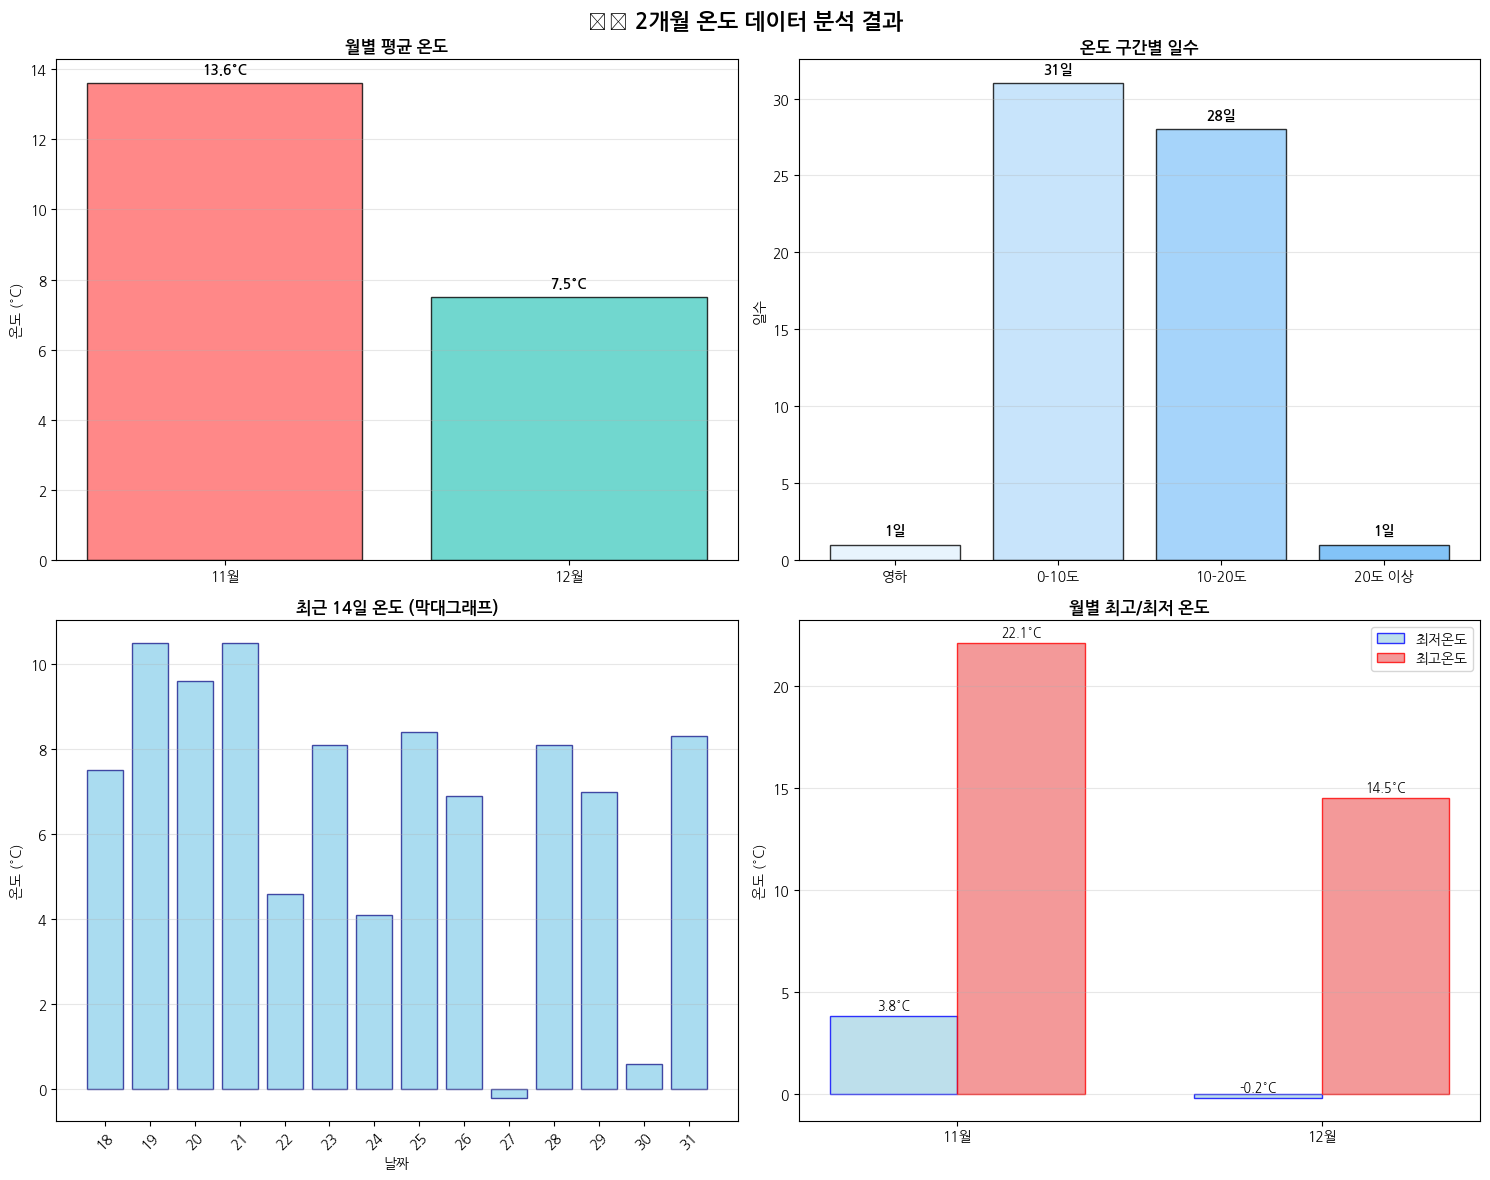

✅ 막대 그래프 생성 완료!


In [7]:
# ============================================================================
# 5단계: 막대 그래프 생성
# ============================================================================

def create_temperature_charts(db_name='temperature.db'):
    """다양한 온도 막대 그래프 생성"""
    print(f"\n5️⃣  온도 막대 그래프 생성")

    conn = sqlite3.connect(db_name)

    # 전체 데이터 조회
    df = pd.read_sql_query("SELECT * FROM temperature_data", conn)

    # 월별 평균 온도 조회
    monthly_avg = pd.read_sql_query("""
        SELECT
            month,
            ROUND(AVG(temperature), 1) as avg_temp,
            COUNT(*) as days
        FROM temperature_data
        GROUP BY month
        ORDER BY month
    """, conn)

    # 온도 구간별 일수 조회
    temp_ranges = pd.read_sql_query("""
        SELECT
            CASE
                WHEN temperature < 0 THEN '영하'
                WHEN temperature < 10 THEN '0-10도'
                WHEN temperature < 20 THEN '10-20도'
                ELSE '20도 이상'
            END as temp_range,
            COUNT(*) as days
        FROM temperature_data
        GROUP BY temp_range
        ORDER BY
            CASE
                WHEN temperature < 0 THEN 1
                WHEN temperature < 10 THEN 2
                WHEN temperature < 20 THEN 3
                ELSE 4
            END
    """, conn)

    conn.close()

    # 그래프 생성
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('2개월 온도 데이터 분석 결과', fontsize=16, fontweight='bold')

    # 1. 월별 평균 온도
    ax1 = axes[0, 0]
    months = ['11월', '12월']
    bars1 = ax1.bar(months, monthly_avg['avg_temp'],
                    color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black')
    ax1.set_title('월별 평균 온도', fontweight='bold')
    ax1.set_ylabel('온도 (°C)')
    ax1.grid(axis='y', alpha=0.3)

    # 막대 위에 값 표시
    for bar, temp in zip(bars1, monthly_avg['avg_temp']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{temp}°C', ha='center', va='bottom', fontweight='bold')

    # 2. 온도 구간별 일수
    ax2 = axes[0, 1]
    colors = ['#E3F2FD', '#BBDEFB', '#90CAF9', '#64B5F6']
    bars2 = ax2.bar(temp_ranges['temp_range'], temp_ranges['days'],
                    color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('온도 구간별 일수', fontweight='bold')
    ax2.set_ylabel('일수')
    ax2.grid(axis='y', alpha=0.3)

    # 막대 위에 값 표시
    for bar, days in zip(bars2, temp_ranges['days']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{days}일', ha='center', va='bottom', fontweight='bold')

    # 3. 일별 온도 추이 (막대그래프)
    ax3 = axes[1, 0]
    # 최근 14일 데이터만 표시 (너무 많으면 복잡함)
    recent_df = df.tail(14)
    bars3 = ax3.bar(range(len(recent_df)), recent_df['temperature'],
                    color='skyblue', alpha=0.7, edgecolor='navy')
    ax3.set_title('최근 14일 온도 (막대그래프)', fontweight='bold')
    ax3.set_ylabel('온도 (°C)')
    ax3.set_xlabel('날짜')
    ax3.set_xticks(range(len(recent_df)))
    ax3.set_xticklabels([d.split('-')[2] for d in recent_df['date']], rotation=45)
    ax3.grid(axis='y', alpha=0.3)

    # 4. 월별 최고/최저 온도 비교
    ax4 = axes[1, 1]
    monthly_minmax = pd.read_sql_query("""
        SELECT
            month,
            MIN(temperature) as min_temp,
            MAX(temperature) as max_temp
        FROM temperature_data
        GROUP BY month
        ORDER BY month
    """, sqlite3.connect('temperature.db'))

    x = np.arange(len(months))
    width = 0.35

    bars4_min = ax4.bar(x - width/2, monthly_minmax['min_temp'], width,
                       label='최저온도', color='lightblue', alpha=0.8, edgecolor='blue')
    bars4_max = ax4.bar(x + width/2, monthly_minmax['max_temp'], width,
                       label='최고온도', color='lightcoral', alpha=0.8, edgecolor='red')

    ax4.set_title('월별 최고/최저 온도', fontweight='bold')
    ax4.set_ylabel('온도 (°C)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(months)
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)

    # 막대 위에 값 표시
    for bar, temp in zip(bars4_min, monthly_minmax['min_temp']):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{temp}°C', ha='center', va='bottom', fontsize=9)

    for bar, temp in zip(bars4_max, monthly_minmax['max_temp']):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{temp}°C', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    print("✅ 막대 그래프 생성 완료!")

# 막대 그래프 생성
create_temperature_charts()


# 6) 분석

In [8]:
# ============================================================================
# 6단계:  분석 및
# ============================================================================

def additional_analysis(db_name='temperature.db'):
    """추가적인 온도 데이터 분석"""
    print(f"\n6️⃣  추가 분석 및 인사이트")

    conn = sqlite3.connect(db_name)

    # 가장 추운 날과 더운 날
    query_extreme = """
        SELECT
            date, temperature,
            CASE
                WHEN temperature = (SELECT MIN(temperature) FROM temperature_data) THEN '가장 추운 날'
                WHEN temperature = (SELECT MAX(temperature) FROM temperature_data) THEN '가장 더운 날'
            END as type
        FROM temperature_data
        WHERE temperature = (SELECT MIN(temperature) FROM temperature_data)
           OR temperature = (SELECT MAX(temperature) FROM temperature_data)
        ORDER BY temperature
    """

    extreme_days = pd.read_sql_query(query_extreme, conn)
    print("🌡️  극값 날짜:")
    for _, row in extreme_days.iterrows():
        print(f"   {row['type']}: {row['date']} ({row['temperature']}°C)")

    # 온도 변화 트렌드
    query_trend = """
        SELECT
            date, temperature,
            LAG(temperature) OVER (ORDER BY date) as prev_temp,
            temperature - LAG(temperature) OVER (ORDER BY date) as temp_change
        FROM temperature_data
        ORDER BY date
    """

    trend_data = pd.read_sql_query(query_trend, conn)

    # 가장 큰 온도 변화
    max_increase = trend_data.loc[trend_data['temp_change'].idxmax()]
    max_decrease = trend_data.loc[trend_data['temp_change'].idxmin()]

    print(f"\n📈 온도 변화:")
    print(f"   가장 큰 상승: {max_increase['date']} ({max_increase['temp_change']:+.1f}°C)")
    print(f"   가장 큰 하강: {max_decrease['date']} ({max_decrease['temp_change']:+.1f}°C)")

    conn.close()

# 추가 분석 실행
additional_analysis()


6️⃣  추가 분석 및 인사이트
🌡️  극값 날짜:
   가장 추운 날: 2024-12-27 (-0.2°C)
   가장 더운 날: 2024-11-14 (22.1°C)

📈 온도 변화:
   가장 큰 상승: 2024-11-30 (+12.0°C)
   가장 큰 하강: 2024-11-24 (-11.6°C)
